# APPLE Stock Price Forecasting

### Import libraries

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Loading the dataset from yfinance

In [ ]:
ticker = "AAPL"
df = yf.download(ticker, start="2015-01-01", end="2024-12-31", progress=False)

df.head(10)  ## loading top 10 observation from the datase

#### Flatten the MultiIndex columns

In [32]:
df.columns = ['_'.join(col).strip() for col in df.columns.values]
# Check the new columns
print(df.columns)

Index(['Close_AAPL', 'High_AAPL', 'Low_AAPL', 'Open_AAPL', 'Volume_AAPL'], dtype='str')


## Apple Stock Price Dataset (2015 - 2024)

This dataset contains historical stock prices for **Apple Inc. (AAPL)**. The data is structured as a **pandas DataFrame with a MultiIndex for columns**, where the first level represents the **price type** and the second level represents the **ticker**. The **index** represents the **date** of each trading day.

---

### **Columns**

| Price Type | Ticker |
|------------|--------|
| Close      | AAPL   |
| High       | AAPL   |
| Low        | AAPL   |
| Open       | AAPL   |
| Volume     | AAPL   |

- **Open**: Stock price at the start of the trading day  
- **High**: Highest stock price during the day  
- **Low**: Lowest stock price during the day  
- **Close**: Stock price at the end of the trading day  
- **Volume**: Number of shares traded during the day  

---
> The dataset can be used for **time series analysis, forecasting, or visualization** of Apple’s stock performance over time.


#### See the total no. of observations and Columns

In [5]:
rows, columns = df.shape
print(f"This dataset contains {rows} Observations overtime and {columns} columns.")

This dataset contains 2515 Observations overtime and 5 columns.


### ✅ Time Series Data Validation Checklist

- [x] Check for missing dates and timestamp gaps
- [x] Verify absence of duplicate timestamps
- [ ] Descriptive Statistics- mean, mediun mode & outlier
- [x] Date column converted to `datetime` format
- [x] Validate numerical data types for all features  
- [x] Time index sorted in chronological order
- [x] Analyze stationarity of the time series  
- [x] Identify trends and volatility patterns  
- [x] Examine autocorrelation and partial autocorrelation  
- [x] Apply time-aware train–test split (no shuffling)



#### Checking for missing value in dataset

In [35]:
### Funciton to display data informaiton

def Columns_Info(df):
    """
    Display a detailed table showing:
    - Number of unique values per column
    - Number of null values
    - Data type
    - Total rows, total columns, count of each data type
    """
    # Column-wise info
    unique_counts = {
        "Column": df.columns,
        "Unique Values": [df[col].nunique() for col in df.columns],
        "Null Values": [df[col].isna().sum() for col in df.columns],
        "Data Type": [df[col].dtype for col in df.columns]
    }
    result_df = pd.DataFrame(unique_counts)
    
    # Overall info
    total_rows = df.shape[0]
    total_cols = df.shape[1]
    dtype_counts = df.dtypes.value_counts().to_dict()
    
    # Display
    print(f"Total Rows: {total_rows}")
    print(f"Total Columns: {total_cols}")
    print("Column types count:", dtype_counts)
    print("-"*50)
    display(result_df)

In [14]:
Columns_Info(df)

Total Rows: 2515
Total Columns: 5
Column types count: {dtype('float64'): 4, dtype('int64'): 1}
--------------------------------------------------


,Column,Unique Values,Null Values,Data Type
0,"(Close, AAPL)",2481,0,float64
1,"(High, AAPL)",2515,0,float64
2,"(Low, AAPL)",2515,0,float64
3,"(Open, AAPL)",2515,0,float64
4,"(Volume, AAPL)",2508,0,int64


### 🔍 Key Inferences

- ✅ **No missing values** across all columns, indicating a **clean and reliable dataset**.
- 📈 **Price columns (`Open`, `High`, `Low`, `Close`)** are stored as floating-point numbers, which is ideal for statistical analysis and modeling.
- 📉 **Volume** is stored as an integer, representing the number of shares traded per day.
- 🔁 The `Close` and `Volume` columns have slightly fewer unique values than total rows, suggesting **repeated values on some trading days**, which is common in financial markets.
- 🕒 With over **2,500 records**, the dataset provides a **long historical range**, making it well-suited for:
  - Time series analysis
  - Trend detection
  - Volatility analysis
  - Stock price forecasting models (ARIMA, LSTM, etc.)


#### Verify absence of duplicate timestamps

In [18]:
duplicate_check = df.index.duplicated().sum()

if duplicate_check == 0:
    print("✅ No duplicate timestamps found in the dataset.")
else:
    print(f"⚠️ Dataset contains {duplicate_check} duplicate timestamps.")


✅ No duplicate timestamps found in the dataset.


#### Date column converted to datetime format

In [22]:
df.index.name

'Date'

Using the Date as a `DatetimeIndex` ensures chronological ordering and enables time-aware operations like resampling, rolling windows, and date-based slicing.  
It also improves modeling accuracy and prevents data leakage in time series analysis.


In [21]:
if isinstance(df.index, pd.DatetimeIndex):
    print("✅ Date index is successfully converted to pandas.DatetimeIndex.")
else:
    print("❌ Date index is not in datetime format.")


✅ Date index is successfully converted to pandas.DatetimeIndex.


 #### Descriptive Statistics- mean, mediun mode & outlier

In [34]:
df.describe()

,Close_AAPL,High_AAPL,Low_AAPL,Open_AAPL,Volume_AAPL
count,2515.000000,2515.000000,2515.000000,2515.000000,2.515000e+03
mean,93.797132,94.707869,92.783453,93.709472,1.171162e+08
std,65.380822,65.973200,64.693208,65.298503,6.839222e+07
min,20.604080,20.907412,20.405658,20.526531,2.323470e+07
25%,35.203342,35.606982,34.844188,35.234246,7.108655e+07
50%,64.373764,64.723190,63.565052,64.132057,1.003845e+08
75%,150.219711,151.947371,148.203846,150.002031,1.426222e+08
max,257.853790,258.928945,256.470064,257.027541,6.488252e+08


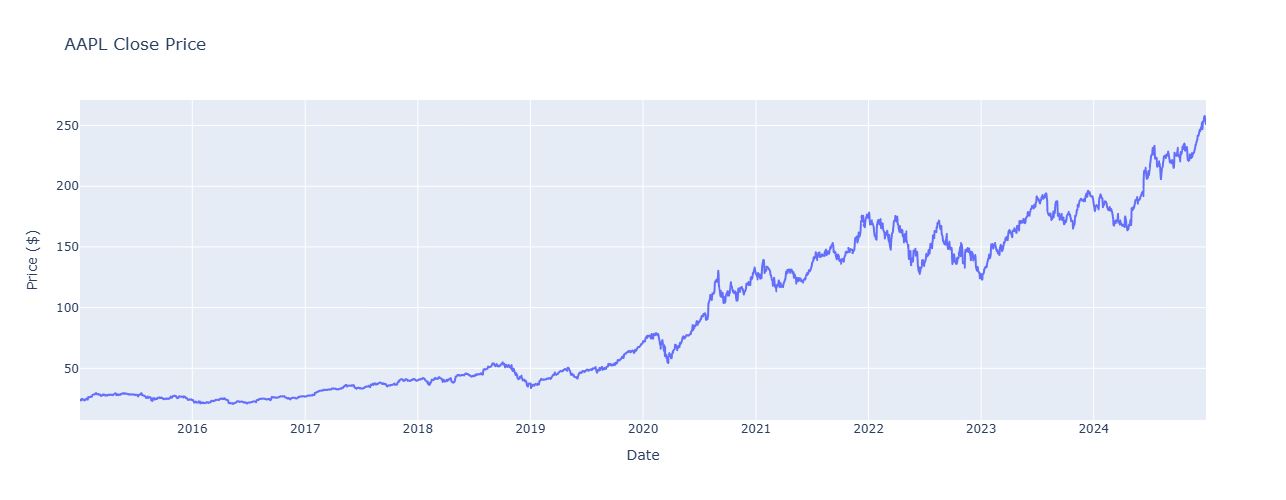

In [33]:
import plotly.express as px

fig = px.line(df, x=df.index, y='Close_AAPL', title='AAPL Close Price')
fig.update_layout(width=900, height=500, xaxis_title='Date', yaxis_title='Price ($)')
fig.show()

In [38]:
window = 20  # e.g., 20 days
rolling_mean = df['Close'].rolling(window=window).mean()
rolling_std = df['Close'].rolling(window=window).std()

outliers = df[(df['Close'] > rolling_mean + 3*rolling_std) | 
              (df['Close'] < rolling_mean - 3*rolling_std)]


#### Time index sorted in chronological order

In [40]:
# Check if Date index is sorted
if df.index.is_monotonic_increasing:
    print("✅ The Date index is sorted in chronological order.")
    print(f"First date: {df.index.min()} | Last date: {df.index.max()}")
else:
    print("⚠️ The Date index is NOT sorted! Sorting now...")
    df = df.sort_index()
    print("✅ Date index sorted successfully.")
    print(f"First date: {df.index.min()} | Last date: {df.index.max()}")


✅ The Date index is sorted in chronological order.
First date: 2015-01-02 00:00:00 | Last date: 2024-12-30 00:00:00
